In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from pathlib import Path 

%matplotlib inline


In [4]:
import os
os.chdir("/content/gdrive/My Drive/dataset_adni/augmented_data")

In [2]:
def load_data(dir_list):
    """
    Read images, resize and normalize them. 
    """
    # load all images in a directory
    X = []
    y = []
    #image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory): 
            # load the image
            image = cv2.imread(directory+'//'+filename)
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            if directory[-7:] == 'AD_crop':#directory[-6:]
                y.append([2])
            elif directory[-7:] =='MI_crop':
                y.append([1])
            else:
                y.append([3])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [3]:
X, y = load_data(['MI_crop','CN_crop','AD_crop'])


Number of examples is: 2934
X shape is: (2934, 224, 224, 3)
y shape is: (2934, 1)


In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [7]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 2053
number of development examples = 441
number of test examples = 440
X_train shape: (2053, 224, 224, 3)
Y_train shape: (2053, 1)
X_val (dev) shape: (441, 224, 224, 3)
Y_val (dev) shape: (441, 1)
X_test shape: (440, 224, 224, 3)
Y_test shape: (440, 1)


In [8]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"



In [9]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    
    return score


In [10]:
IMAGE_SHAPE = (224, 224, 3)
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=4, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=4, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model


In [11]:
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3}, metrics=['accuracy'])






In [13]:
log_file_name = f'alzheimer_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [14]:
i=1
filepath="cnn-parameters-improvement{i}"
i=i+1
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


In [14]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=16, epochs=100, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/100
129/129 [==============================] - 280s 2s/step - loss: 1.7243 - main_loss: 1.1330 - aux1_loss: 0.9656 - aux2_loss: 1.0053 - main_accuracy: 0.3931 - aux1_accuracy: 0.5373 - aux2_accuracy: 0.4623 - val_loss: 3.2730 - val_main_loss: 2.2475 - val_aux1_loss: 1.0508 - val_aux2_loss: 2.3674 - val_main_accuracy: 0.3129 - val_aux1_accuracy: 0.4376 - val_aux2_accuracy: 0.3129
Epoch 2/100
129/129 [==============================] - 247s 2s/step - loss: 0.9106 - main_loss: 0.6327 - aux1_loss: 0.4394 - aux2_loss: 0.4872 - main_accuracy: 0.6659 - aux1_accuracy: 0.8052 - aux2_accuracy: 0.7832 - val_loss: 1.4501 - val_main_loss: 0.9850 - val_aux1_loss: 0.7238 - val_aux2_loss: 0.8264 - val_main_accuracy: 0.6100 - val_aux1_accuracy: 0.7120 - val_aux2_accuracy: 0.6531
Epoch 3/100
129/129 [==============================] - 247s 2s/step - loss: 0.6789 - main_loss: 0.4877 - aux1_loss: 0.2968 - aux2_loss: 0.3407 - main_accuracy: 0.7832 - aux1_accuracy: 0.8860 - aux2_accuracy: 0.8758 - val

Epoch 22/100
129/129 [==============================] - 247s 2s/step - loss: 0.0540 - main_loss: 0.0370 - aux1_loss: 0.0275 - aux2_loss: 0.0293 - main_accuracy: 0.9854 - aux1_accuracy: 0.9903 - aux2_accuracy: 0.9878 - val_loss: 0.3282 - val_main_loss: 0.2137 - val_aux1_loss: 0.1802 - val_aux2_loss: 0.2014 - val_main_accuracy: 0.9592 - val_aux1_accuracy: 0.9569 - val_aux2_accuracy: 0.9569
Epoch 23/100
129/129 [==============================] - 247s 2s/step - loss: 0.0556 - main_loss: 0.0370 - aux1_loss: 0.0294 - aux2_loss: 0.0328 - main_accuracy: 0.9883 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9888 - val_loss: 0.2842 - val_main_loss: 0.1857 - val_aux1_loss: 0.1423 - val_aux2_loss: 0.1862 - val_main_accuracy: 0.9546 - val_aux1_accuracy: 0.9524 - val_aux2_accuracy: 0.9478
Epoch 24/100
129/129 [==============================] - 247s 2s/step - loss: 0.0111 - main_loss: 0.0071 - aux1_loss: 0.0056 - aux2_loss: 0.0077 - main_accuracy: 0.9990 - aux1_accuracy: 0.9990 - aux2_accuracy: 0.9985 - 

Epoch 43/100
129/129 [==============================] - 246s 2s/step - loss: 0.1686 - main_loss: 0.1205 - aux1_loss: 0.0718 - aux2_loss: 0.0883 - main_accuracy: 0.9781 - aux1_accuracy: 0.9786 - aux2_accuracy: 0.9795 - val_loss: 0.3259 - val_main_loss: 0.2169 - val_aux1_loss: 0.1793 - val_aux2_loss: 0.1838 - val_main_accuracy: 0.9388 - val_aux1_accuracy: 0.9410 - val_aux2_accuracy: 0.9433
Epoch 44/100
129/129 [==============================] - 247s 2s/step - loss: 0.0420 - main_loss: 0.0274 - aux1_loss: 0.0252 - aux2_loss: 0.0234 - main_accuracy: 0.9917 - aux1_accuracy: 0.9912 - aux2_accuracy: 0.9912 - val_loss: 0.3376 - val_main_loss: 0.2324 - val_aux1_loss: 0.1581 - val_aux2_loss: 0.1924 - val_main_accuracy: 0.9592 - val_aux1_accuracy: 0.9615 - val_aux2_accuracy: 0.9546
Epoch 45/100
129/129 [==============================] - 247s 2s/step - loss: 0.0490 - main_loss: 0.0321 - aux1_loss: 0.0304 - aux2_loss: 0.0261 - main_accuracy: 0.9907 - aux1_accuracy: 0.9912 - aux2_accuracy: 0.9927 - 

Epoch 64/100
129/129 [==============================] - 245s 2s/step - loss: 0.0014 - main_loss: 7.7672e-04 - aux1_loss: 0.0013 - aux2_loss: 8.4133e-04 - main_accuracy: 0.9995 - aux1_accuracy: 0.9990 - aux2_accuracy: 0.9995 - val_loss: 0.4845 - val_main_loss: 0.3573 - val_aux1_loss: 0.2163 - val_aux2_loss: 0.2074 - val_main_accuracy: 0.9637 - val_aux1_accuracy: 0.9637 - val_aux2_accuracy: 0.9660
Epoch 65/100
129/129 [==============================] - 245s 2s/step - loss: 0.0017 - main_loss: 0.0011 - aux1_loss: 9.1961e-04 - aux2_loss: 0.0010 - main_accuracy: 0.9995 - aux1_accuracy: 0.9990 - aux2_accuracy: 0.9995 - val_loss: 0.4632 - val_main_loss: 0.3344 - val_aux1_loss: 0.2221 - val_aux2_loss: 0.2073 - val_main_accuracy: 0.9615 - val_aux1_accuracy: 0.9569 - val_aux2_accuracy: 0.9592
Epoch 66/100
129/129 [==============================] - 247s 2s/step - loss: 0.0017 - main_loss: 0.0013 - aux1_loss: 9.1984e-04 - aux2_loss: 5.6551e-04 - main_accuracy: 0.9990 - aux1_accuracy: 0.9995 - aux2

Epoch 85/100
129/129 [==============================] - 247s 2s/step - loss: 0.0422 - main_loss: 0.0273 - aux1_loss: 0.0200 - aux2_loss: 0.0296 - main_accuracy: 0.9917 - aux1_accuracy: 0.9951 - aux2_accuracy: 0.9927 - val_loss: 0.5149 - val_main_loss: 0.3470 - val_aux1_loss: 0.2862 - val_aux2_loss: 0.2736 - val_main_accuracy: 0.9433 - val_aux1_accuracy: 0.9478 - val_aux2_accuracy: 0.9433
Epoch 86/100
129/129 [==============================] - 247s 2s/step - loss: 0.0529 - main_loss: 0.0335 - aux1_loss: 0.0322 - aux2_loss: 0.0324 - main_accuracy: 0.9922 - aux1_accuracy: 0.9893 - aux2_accuracy: 0.9927 - val_loss: 0.3444 - val_main_loss: 0.2179 - val_aux1_loss: 0.2370 - val_aux2_loss: 0.1845 - val_main_accuracy: 0.9569 - val_aux1_accuracy: 0.9592 - val_aux2_accuracy: 0.9524
Epoch 87/100
129/129 [==============================] - 247s 2s/step - loss: 0.0213 - main_loss: 0.0147 - aux1_loss: 0.0123 - aux2_loss: 0.0098 - main_accuracy: 0.9966 - aux1_accuracy: 0.9976 - aux2_accuracy: 0.9976 - 

In [15]:
history = model.history.history

In [16]:
for key in history.keys():
    print(key)

loss
main_loss
aux1_loss
aux2_loss
main_accuracy
aux1_accuracy
aux2_accuracy
val_loss
val_main_loss
val_aux1_loss
val_aux2_loss
val_main_accuracy
val_aux1_accuracy
val_aux2_accuracy


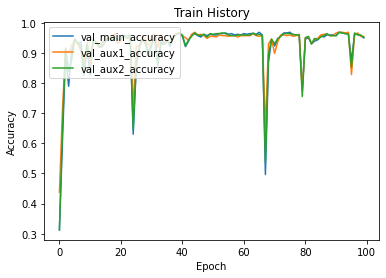

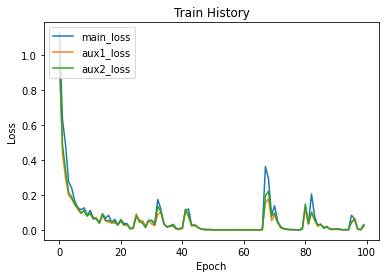

In [17]:
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history, 'Epoch', 'Accuracy', ('val_main_accuracy', 'val_aux1_accuracy', 'val_aux2_accuracy'))
show_train_history(history, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))


In [18]:
model.metrics_names

['loss',
 'main_loss',
 'aux1_loss',
 'aux2_loss',
 'main_accuracy',
 'aux1_accuracy',
 'aux2_accuracy']

In [19]:
loss,main_loss,aux1_loss,aux2_loss,main_accuracy,aux1_accuracy,aux2_accuracy = model.evaluate(x=X_test, y=y_test)


14/14 [==============================] - 13s 917ms/step - loss: 0.2226 - main_loss: 0.1492 - aux1_loss: 0.1154 - aux2_loss: 0.1296 - main_accuracy: 0.9682 - aux1_accuracy: 0.9614 - aux2_accuracy: 0.9682


In [20]:
print (f"Main Loss = {main_loss*100}")
print (f"Aux1 Loss = {aux1_loss*100}")
print (f"Aux2 Loss = {aux2_loss*100}")
print (f"Main Accuracy = {main_accuracy*100}")
print (f"Aux1 accuracy = {aux1_accuracy*100}")
print (f"Aux2 Accuracy = {aux2_accuracy*100}")

Main Loss = 14.915856719017029
Aux1 Loss = 11.535145342350006
Aux2 Loss = 12.957258522510529
Main Accuracy = 96.81817889213562
Aux1 accuracy = 96.13636136054993
Aux2 Accuracy = 96.81817889213562


In [21]:
loss,main_loss,aux1_loss,aux2_loss,main_accuracy,aux1_accuracy,aux2_accuracy = model.evaluate(x=X_val, y=y_val)
print (f"Main Loss = {main_loss*100}")
print (f"Aux1 Loss = {aux1_loss*100}")
print (f"Aux2 Loss = {aux2_loss*100}")
print (f"Main Accuracy = {main_accuracy*100}")
print (f"Aux1 accuracy = {aux1_accuracy*100}")
print (f"Aux2 Accuracy = {aux2_accuracy*100}")

14/14 [==============================] - 13s 917ms/step - loss: 0.3086 - main_loss: 0.1881 - aux1_loss: 0.2113 - aux2_loss: 0.1907 - main_accuracy: 0.9501 - aux1_accuracy: 0.9546 - aux2_accuracy: 0.9501
Main Loss = 18.805350363254547
Aux1 Loss = 21.1260586977005
Aux2 Loss = 19.067072868347168
Main Accuracy = 95.01133561134338
Aux1 accuracy = 95.46485543251038
Aux2 Accuracy = 95.01133561134338
